In [22]:
import os
import sys
cwd = os.getcwd()
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, os.path.join(cwd, "../"))

import pickle
import torch
import importlib
import numpy as np
import pandas as pd
import copy

import src.bin.tensorify as tensorify
import src.utils.data_conversion_utils as conversions
import src.data_manager.student_life_var_binned_data_manager as data_manager
import src.bin.trainer as trainer

from sklearn import metrics

from torch import nn
from src import definitions
from src.bin import validations
from src.bin import statistics
from src.bin import plotting
from src.utils.read_utils import read_pickle
from src.utils import student_utils
from src.data_manager import sub_sampler
from src.data_manager import cross_val
from src.data_manager import helper as data_manager_helper

from tabulate import tabulate 
import src.models.simple as simple_models   

pd.set_option('max_rows', 10000)

importlib.reload(validations)
importlib.reload(data_manager_helper)
importlib.reload(sub_sampler)
importlib.reload(statistics)
importlib.reload(cross_val)
importlib.reload(definitions)
importlib.reload(conversions)
importlib.reload(tensorify)
importlib.reload(plotting)
importlib.reload(trainer)
importlib.reload(data_manager)
importlib.reload(student_utils)
importlib.reload(simple_models)
feature_list = data_manager.FEATURE_LIST

##### Pickle ######
data = read_pickle('../data/training_data/most_representative_6_hr_b_imputed_normalized_prev_stress_data.pkl')

### Data ####

student_list = [53, 46, 7, 49, 22, 24, 2]
data = data_manager.get_data_for_training_in_dict_format(*student_list, normalize=True, 
                                                         fill_na=True, flatten_sequence=False)

# data = sub_sampler.get_sub_sampled_sequences(data)

# print(data['data'].keys())
# print(data['data']['2_4_16_4_1'][-1])


#### Randomize ######
train_ids, val_ids, test_ids = cross_val.random_stratified_splits(data)
data['train_ids'] = train_ids
data['val_ids'] = val_ids
data['test_ids'] = test_ids

############# Stats ########### 
# unnormalized_data = data_manager.get_data_for_training_in_dict_format(*student_list, normalize=False, fill_na=False)
# statistics_df, raw_df = statistics.get_statistics_on_data_dict(unnormalized_data, feature_list)
print(statistics.get_train_test_val_label_counts_from_raw_data(data))

      Train    Val    Test
--  -------  -----  ------
 0       54     22      14
 1       49     20      13
 2       31     12       9


In [23]:
################################## Init ##################################
hidden_size = 64
dropout = 0.85
learning_rate = 0.00005
n_epochs = 150
first_key = next(iter(data['data'].keys()))
num_features = len(data['data'][first_key][0][0])
covariates = len(data['data'][first_key][3])

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Left Out Student:  1


/home/abhinav/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.85 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/abhinav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


xxxxxxxxxxxxxx epoch: 0 xxxxxxxxxxxxxx


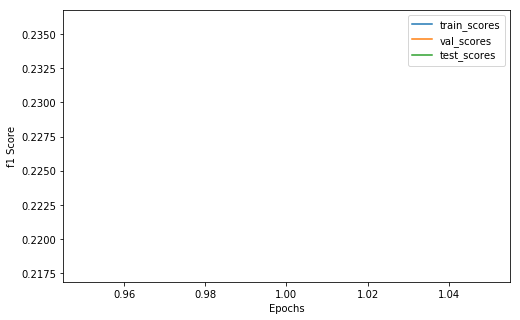

Cofusion Matrix For Val Set: 
--  -  -
22  0  0
20  0  0
12  0  0
--  -  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0      134     54      36
 1        0      0       0
 2        0      0       0
xxxxxxxxxxxxxx epoch: 10 xxxxxxxxxxxxxx


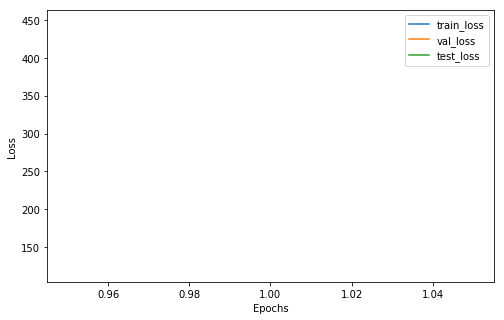

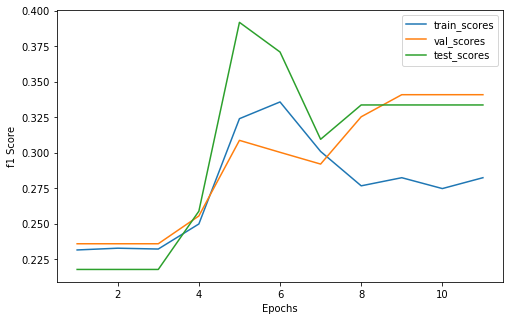

Cofusion Matrix For Val Set: 
--  --  -
10  12  0
 9  11  0
 4   8  0
--  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0       51     23      17
 1       81     31      19
 2        2      0       0
xxxxxxxxxxxxxx epoch: 20 xxxxxxxxxxxxxx


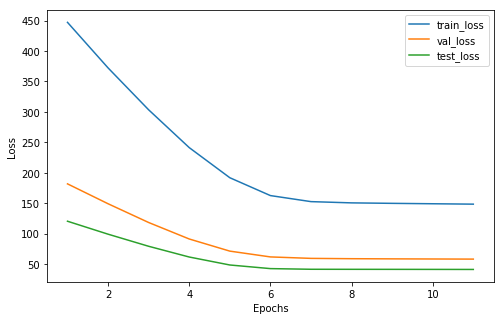

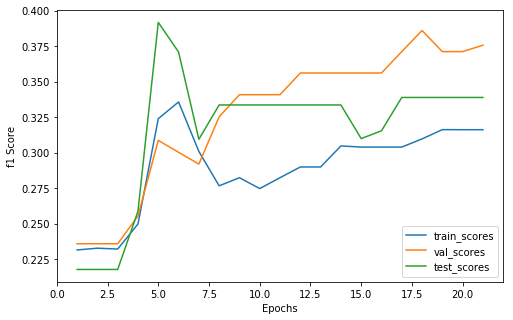

Cofusion Matrix For Val Set: 
--  --  -
10  12  0
 6  13  1
 4   8  0
--  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0       51     20      18
 1       80     33      17
 2        3      1       1
xxxxxxxxxxxxxx epoch: 30 xxxxxxxxxxxxxx


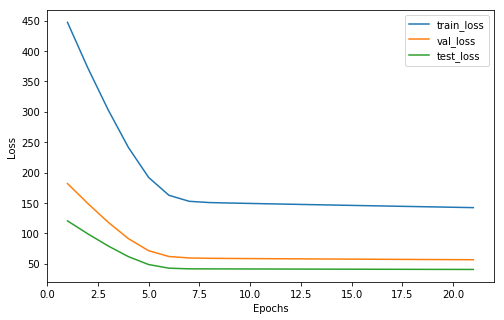

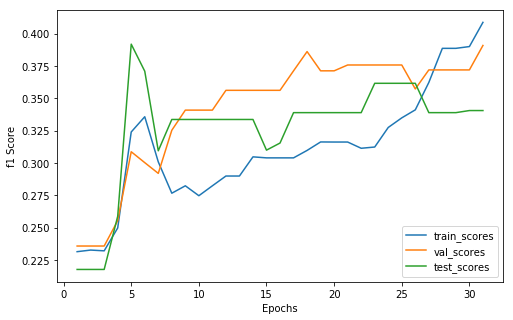

Cofusion Matrix For Val Set: 
--  --  -
10  12  0
 5  14  1
 4   8  0
--  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0       55     19      17
 1       69     34      18
 2       10      1       1
xxxxxxxxxxxxxx epoch: 40 xxxxxxxxxxxxxx


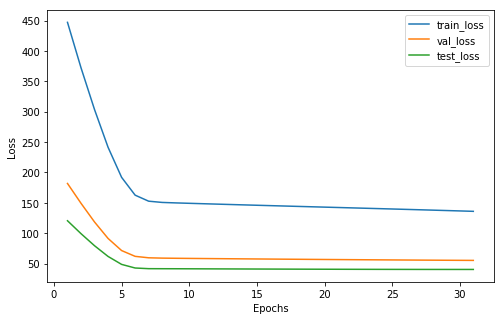

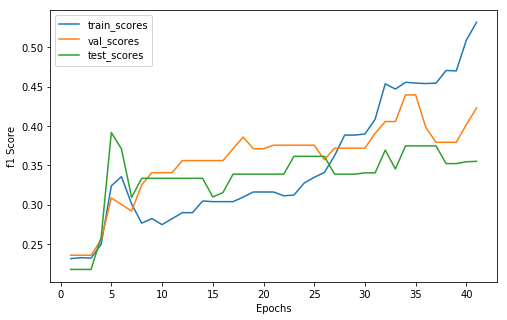

Cofusion Matrix For Val Set: 
-  --  -
9  11  2
2  17  1
4   8  0
-  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0       53     15      12
 1       57     36      17
 2       24      3       7
xxxxxxxxxxxxxx epoch: 50 xxxxxxxxxxxxxx


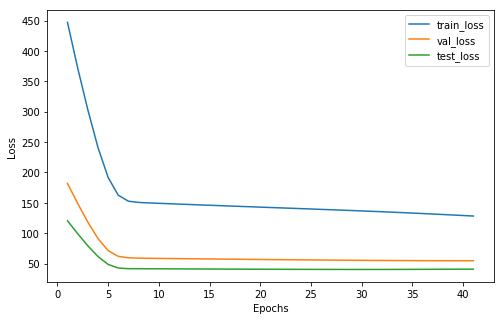

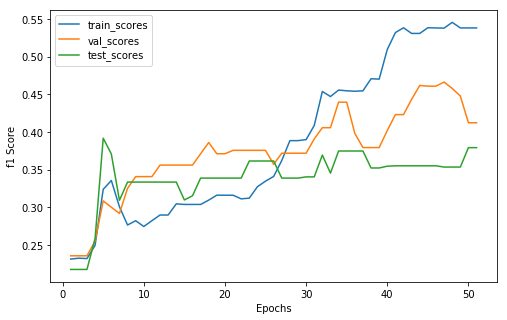

Cofusion Matrix For Val Set: 
--  --  -
10  10  2
 2  14  4
 5   7  0
--  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0       53     17      12
 1       52     31      17
 2       29      6       7
xxxxxxxxxxxxxx epoch: 60 xxxxxxxxxxxxxx


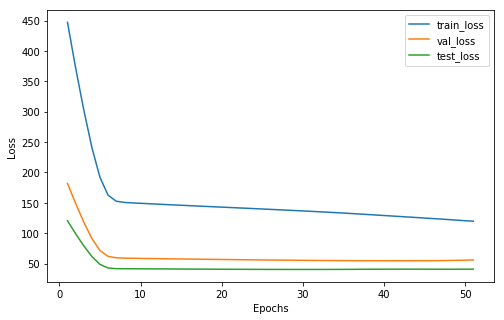

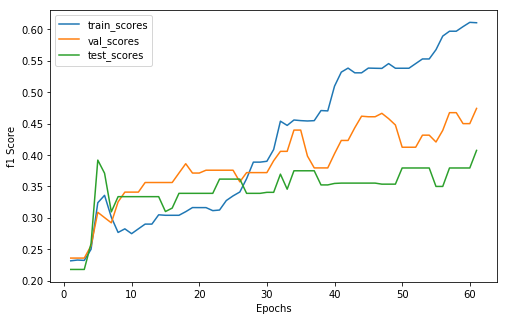

Cofusion Matrix For Val Set: 
--  --  -
12   8  2
 3  12  5
 4   6  2
--  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0       54     19      13
 1       46     26      16
 2       34      9       7
xxxxxxxxxxxxxx epoch: 70 xxxxxxxxxxxxxx


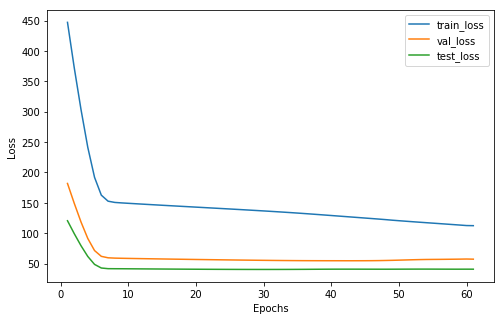

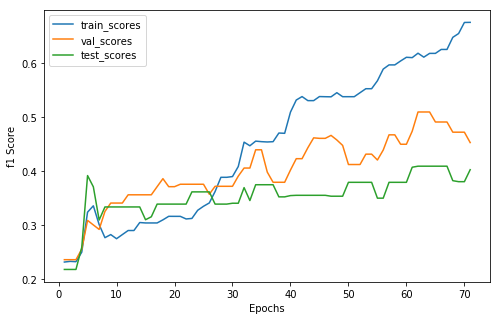

Cofusion Matrix For Val Set: 
--  -  -
14  6  2
 6  9  5
 4  6  2
--  -  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0       63     24      15
 1       37     21      15
 2       34      9       6
xxxxxxxxxxxxxx epoch: 80 xxxxxxxxxxxxxx


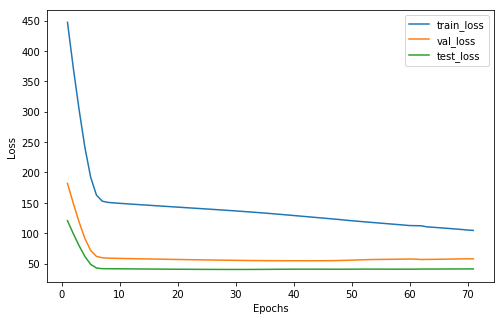

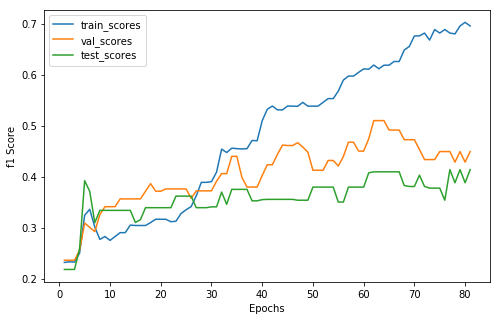

Cofusion Matrix For Val Set: 
--  -  -
15  5  2
 7  8  5
 4  6  2
--  -  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0       65     26      13
 1       35     19      16
 2       34      9       7
xxxxxxxxxxxxxx epoch: 90 xxxxxxxxxxxxxx


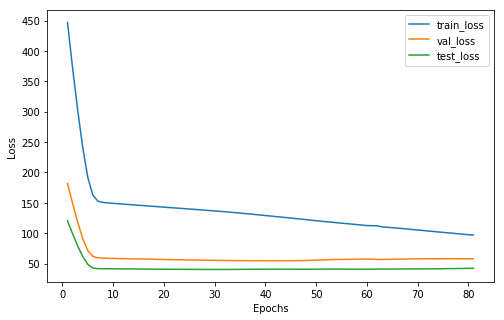

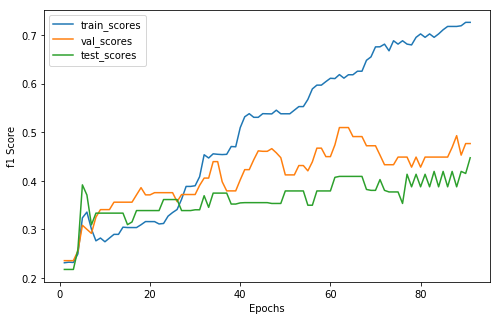

Cofusion Matrix For Val Set: 
--  -  -
14  6  2
 6  9  5
 3  6  3
--  -  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0       62     23      12
 1       37     21      15
 2       35     10       9
xxxxxxxxxxxxxx epoch: 100 xxxxxxxxxxxxxx


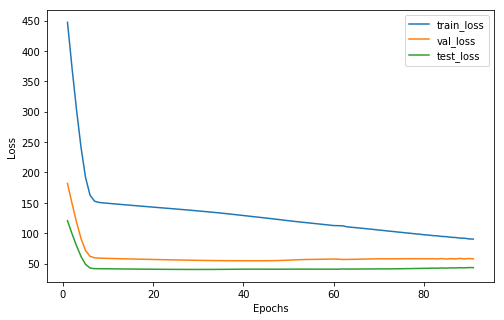

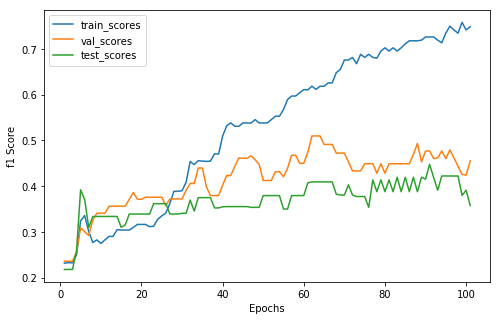

Cofusion Matrix For Val Set: 
--  -  -
14  6  2
 7  8  5
 4  5  3
--  -  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0       62     25      14
 1       37     19      14
 2       35     10       8
xxxxxxxxxxxxxx epoch: 110 xxxxxxxxxxxxxx


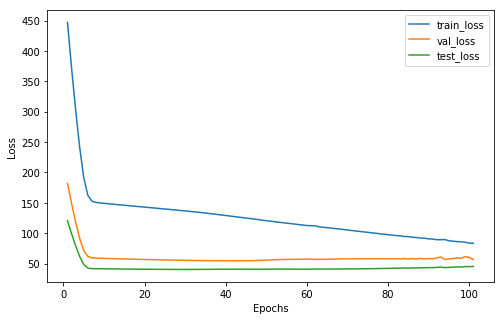

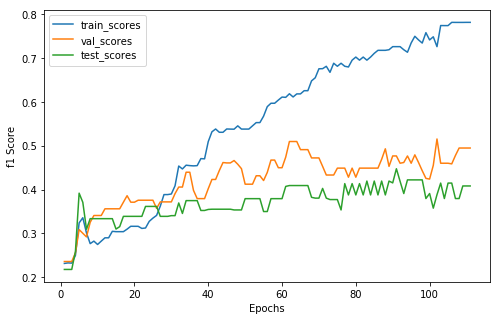

Cofusion Matrix For Val Set: 
--  --  -
14   6  2
 5  10  5
 4   5  3
--  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0       58     23      14
 1       41     21      15
 2       35     10       7
xxxxxxxxxxxxxx epoch: 120 xxxxxxxxxxxxxx


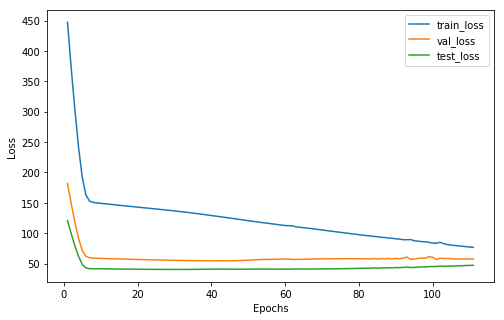

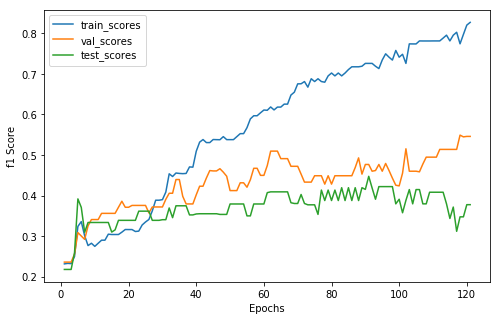

Cofusion Matrix For Val Set: 
--  --  -
14   7  1
 3  13  4
 4   5  3
--  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0       55     21      16
 1       46     25      13
 2       33      8       7
xxxxxxxxxxxxxx epoch: 130 xxxxxxxxxxxxxx


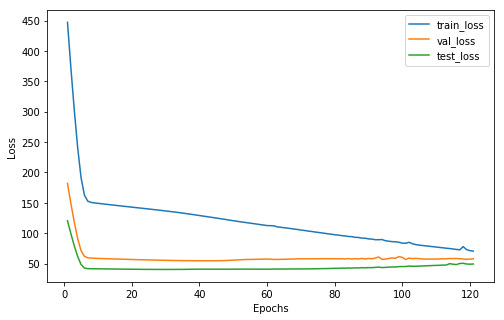

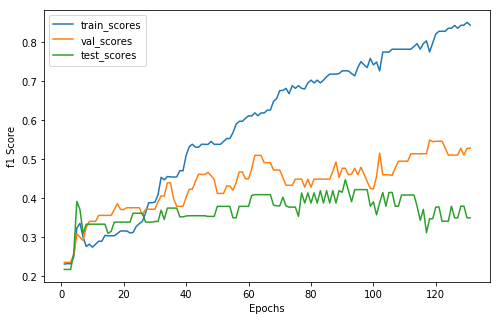

Cofusion Matrix For Val Set: 
--  --  -
14   7  1
 4  12  4
 4   5  3
--  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0       54     22      16
 1       48     24      13
 2       32      8       7
xxxxxxxxxxxxxx epoch: 140 xxxxxxxxxxxxxx


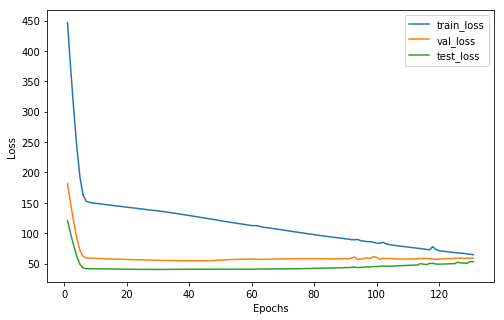

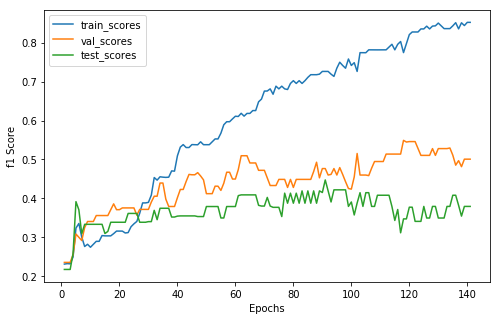

Cofusion Matrix For Val Set: 
--  --  -
15   6  1
 5  11  4
 5   5  2
--  --  -
Predicted Label Distribution:
      Train    Val    Test
--  -------  -----  ------
 0       50     25      15
 1       51     22      14
 2       33      7       7


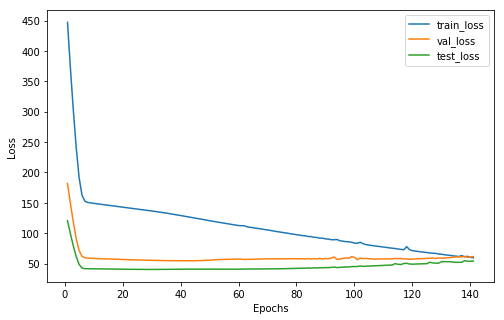

In [24]:
data = tensorify.tensorify_data_gru_d(data)


val_f1_over_splits = []
test_f1_over_splits = []

for data, left_out_student in [(data, 1)]:
    
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print("Left Out Student: ", left_out_student)
    
    model = simple_models.SimpleLSTM(num_features=num_features,
                                     num_classes=3,
                                     hidden_size=hidden_size,
                                     bidirectional=True,
                                     dropout=dropout,
                                     covariates=covariates)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()
    
    loss_over_epochs, scores_over_epochs = plotting.get_empty_stat_over_n_epoch_dictionaries()

    best_val_f1 = 0
    best_test_f1 = 0

    for epoch in range(n_epochs):
        train_loss, train_labels, train_preds =  trainer.evaluate_set(data, 'train_ids', model, criterion, optimizer, 
                                                                      train_covariates=True)
        val_loss, val_labels, val_preds =  trainer.evaluate_set(data, 'val_ids', model, criterion, 
                                                                train_covariates=True)
        test_loss, test_labels, test_preds =  trainer.evaluate_set(data, 'test_ids', model, criterion, 
                                                                   train_covariates=True)

        loss_over_epochs['train_loss'].append(train_loss)
        loss_over_epochs['val_loss'].append(val_loss)
        loss_over_epochs['test_loss'].append(test_loss)

        train_scores = metrics.precision_recall_fscore_support(train_labels, train_preds, average='weighted')
        val_scores = metrics.precision_recall_fscore_support(val_labels, val_preds, average='weighted')
        test_scores = metrics.precision_recall_fscore_support(test_labels, test_preds, average='weighted')

        scores_over_epochs['train_scores'].append(train_scores)
        scores_over_epochs['val_scores'].append(val_scores)
        scores_over_epochs['test_scores'].append(test_scores)
        
        if epoch%10 == 0:
            print("xxxxxxxxxxxxxx epoch: {} xxxxxxxxxxxxxx".format(epoch))
            plotting.plot_score_over_n_epochs(scores_over_epochs, score_type='f1', fig_size=(8,5))
            plotting.plot_loss_over_n_epochs(loss_over_epochs, fig_size=(8, 5))
            print("Cofusion Matrix For Val Set: ")
            print(tabulate( metrics.confusion_matrix(val_labels, val_preds)))
            print("Predicted Label Distribution:")
            print(statistics.get_train_test_val_label_counts_from_predictions(train_preds, val_preds, test_preds))

        best_test_f1 = test_scores[2] if best_test_f1 < test_scores[2] else best_test_f1
        best_val_f1 = val_scores[2] if best_val_f1 < val_scores[2] else best_val_f1

    val_f1_over_splits.append([left_out_student, best_val_f1])
    test_f1_over_splits.append([left_out_student, best_test_f1])
    

In [ ]:
print(val_f1_over_splits)
print(test_f1_over_splits)

In [ ]:
# print(data['train_ids'])
train_ids = set(data['train_ids'])

# print(data['val_ids'])
val_ids = set(data['val_ids'])

# print(data['test_ids'])
test_ids = set(data['test_ids'])

print(train_ids.intersection(val_ids))
print(val_ids.intersection(test_ids))
print(train_ids.intersection(test_ids))